# Implementation of Topic Extraction and Document Clustering

- Author:      Johannes Maucher
- Last update: 14.12.2021

This notebook demonstrates how [gensim](http://radimrehurek.com/gensim/) can be applied for *Latent Semantic Indexing (LSI)*. In LSI a set of abstract topics (features), which are latent in a set of simple texts, is calculated. Then the documents are described and visualised with respect to these abstract features. The notebook is an adoption of the corresponding [gensim LSI tutorial](http://radimrehurek.com/gensim/tut2.html). 

## Collect and filter text documents
A list of very small documents is defined. From the corresponding BoW (Bag of Words) representation all stopwords and all words, which appear only once are removed. The resulting cleaned BoW models of all documents are printed below.  

In [1]:
#!pip install --upgrade gensim

In [2]:
from gensim import corpora, models, similarities

documents = ["Human machine interface for lab abc computer applications",
              "A survey of user opinion of computer system response time",
              "The EPS user interface management system",
              "System and human system engineering testing of EPS",
              "Relation of user perceived response time to error measurement",
              "The generation of random binary unordered trees",
              "The intersection graph of paths in trees",
              "Graph minors IV Widths of trees and well quasi ordering",
              "Graph minors A survey"]
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist] for document in documents]
# remove words that appear only once
all_tokens=[]
for t in texts:
    for w in t:
        all_tokens.append(w)
tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
texts = [[word for word in text if word not in tokens_once]
          for text in texts]
for t in texts:
    print(t)

['human', 'interface', 'computer']
['survey', 'user', 'computer', 'system', 'response', 'time']
['eps', 'user', 'interface', 'system']
['system', 'human', 'system', 'eps']
['user', 'response', 'time']
['trees']
['graph', 'trees']
['graph', 'minors', 'trees']
['graph', 'minors', 'survey']


## Dictionaries and Corpora
The words of the cleaned documents constitute a dictionary, which is persistently saved in the file *deerwester.dict*. The dictionary-method *token2id* displays the dictionary indes of each word.

In [3]:
dictionary = corpora.Dictionary(texts)
dictionary.save('deerwester.dict') # store the dictionary, for future reference
print(dictionary.token2id)

{'computer': 0, 'human': 1, 'interface': 2, 'response': 3, 'survey': 4, 'system': 5, 'time': 6, 'user': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


Next, a corpus is generated, which is a very efficient representation of the cleaned documents. In the corpus each word is represented by it's index in the dictionary. The corpus is persistently saved to file *deerwester.mm*.

In [4]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('deerwester.mm', corpus) # store to disk, for later use

In [5]:
for c in corpus:
    print(c)

[(0, 1), (1, 1), (2, 1)]
[(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
[(2, 1), (5, 1), (7, 1), (8, 1)]
[(1, 1), (5, 2), (8, 1)]
[(3, 1), (6, 1), (7, 1)]
[(9, 1)]
[(9, 1), (10, 1)]
[(9, 1), (10, 1), (11, 1)]
[(4, 1), (10, 1), (11, 1)]


The following code snippet demonstrates how a dictionary and a corpus can be loaded into the python program.

In [6]:
dictionary = corpora.Dictionary.load('deerwester.dict')
corpus = corpora.MmCorpus('deerwester.mm')
for c in corpus:
    print(c)

[(0, 1.0), (1, 1.0), (2, 1.0)]
[(0, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0)]
[(2, 1.0), (5, 1.0), (7, 1.0), (8, 1.0)]
[(1, 1.0), (5, 2.0), (8, 1.0)]
[(3, 1.0), (6, 1.0), (7, 1.0)]
[(9, 1.0)]
[(9, 1.0), (10, 1.0)]
[(9, 1.0), (10, 1.0), (11, 1.0)]
[(4, 1.0), (10, 1.0), (11, 1.0)]


## TF-IDF Model of the corpus
A tf-idf model is generated from the cleaned documents of the corpus and all corpus documents are represented by the vector of tf-idf values of their words.

### TF-IDF Model without document-vector normalisation

In [7]:
tfidf = models.TfidfModel(corpus,normalize=False)  # generate a transformation object and fit it to the corpus documents
corpus_tfidf = tfidf[corpus] # apply the transformation to all corpus documents
for doc in corpus_tfidf:
    print(doc)

[(0, 2.1699250014423126), (1, 2.1699250014423126), (2, 2.1699250014423126)]
[(0, 2.1699250014423126), (3, 2.1699250014423126), (4, 2.1699250014423126), (5, 1.5849625007211563), (6, 2.1699250014423126), (7, 1.5849625007211563)]
[(2, 2.1699250014423126), (5, 1.5849625007211563), (7, 1.5849625007211563), (8, 2.1699250014423126)]
[(1, 2.1699250014423126), (5, 3.1699250014423126), (8, 2.1699250014423126)]
[(3, 2.1699250014423126), (6, 2.1699250014423126), (7, 1.5849625007211563)]
[(9, 1.5849625007211563)]
[(9, 1.5849625007211563), (10, 1.5849625007211563)]
[(9, 1.5849625007211563), (10, 1.5849625007211563), (11, 2.1699250014423126)]
[(4, 2.1699250014423126), (10, 1.5849625007211563), (11, 2.1699250014423126)]


Transform a new document to tf-idf vector. The new document in this example consists of the words 
* *computer (index 0)*, 
* *human (index 1)* 
* 2 times the word *system (index 5)*:

In [8]:
newDoc=[(0,1),(1,1),(5,2)]
newTFIDF=tfidf[newDoc]
print(newTFIDF)

[(0, 2.1699250014423126), (1, 2.1699250014423126), (5, 3.1699250014423126)]


Verify that log2 is applied in the tf-idf calculation:

In [9]:
import numpy as np
np.log2(9/2)

2.169925001442312

### TF-IDF Model with document-vector normalisation

In general it is better to normalise the document vectors, such that each vector has a length of $1$. By applying document normalisation the obtained vectors are *independent* of document length.

In [10]:
tfidf = models.TfidfModel(corpus,normalize=True)  # generate a transformation object and fit it to the corpus documents
corpus_tfidf = tfidf[corpus] # apply the transformation to all corpus documents
for doc in corpus_tfidf:
    print(doc)

[(0, 0.5773502691896257), (1, 0.5773502691896257), (2, 0.5773502691896257)]
[(0, 0.44424552527467476), (3, 0.44424552527467476), (4, 0.44424552527467476), (5, 0.3244870206138555), (6, 0.44424552527467476), (7, 0.3244870206138555)]
[(2, 0.5710059809418182), (5, 0.4170757362022777), (7, 0.4170757362022777), (8, 0.5710059809418182)]
[(1, 0.49182558987264147), (5, 0.7184811607083769), (8, 0.49182558987264147)]
[(3, 0.6282580468670046), (6, 0.6282580468670046), (7, 0.45889394536615247)]
[(9, 1.0)]
[(9, 0.7071067811865475), (10, 0.7071067811865475)]
[(9, 0.5080429008916749), (10, 0.5080429008916749), (11, 0.695546419520037)]
[(4, 0.6282580468670046), (10, 0.45889394536615247), (11, 0.6282580468670046)]


## LSI Model of the corpus
A Latent Semantic Indexing (LSI) model is generated from the given documents. The number of topics that shall be extracted is selected to be two in this example:

In [11]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) # initialize an LSI transformation
corpus_lsi = lsi[corpus_tfidf]
lsi.print_topics(2)

[(0,
  '0.703*"trees" + 0.538*"graph" + 0.402*"minors" + 0.187*"survey" + 0.061*"system" + 0.060*"response" + 0.060*"time" + 0.058*"user" + 0.049*"computer" + 0.035*"interface"'),
 (1,
  '-0.460*"system" + -0.373*"user" + -0.332*"eps" + -0.328*"interface" + -0.320*"time" + -0.320*"response" + -0.293*"computer" + -0.280*"human" + -0.171*"survey" + 0.161*"trees"')]

As shown below, each document is described in the new 2-dimensional space. The dimensions represent the two extracted topics.

In [12]:
x=[]
y=[]
i=0
for doc in corpus_lsi: # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
    print("Document %2d: \t"%i,doc)
    x.append(doc[0][1])
    y.append(doc[1][1])
    i+=1

Document  0: 	 [(0, 0.06600783396090396), (1, -0.520070330636186)]
Document  1: 	 [(0, 0.19667592859142527), (1, -0.7609563167700045)]
Document  2: 	 [(0, 0.08992639972446446), (1, -0.7241860626752518)]
Document  3: 	 [(0, 0.07585847652178185), (1, -0.6320551586003438)]
Document  4: 	 [(0, 0.10150299184980155), (1, -0.573730848300295)]
Document  5: 	 [(0, 0.7032108939378319), (1, 0.1611518021402583)]
Document  6: 	 [(0, 0.8774787673119839), (1, 0.16758906864659454)]
Document  7: 	 [(0, 0.9098624686818584), (1, 0.1408655362871906)]
Document  8: 	 [(0, 0.6165825350569283), (1, -0.05392907566389342)]


The documents can be plotted in the new 2-dimensional space. In this space the documents are clearly partitioned into 2 clusters, each representing one of the 2 topics.

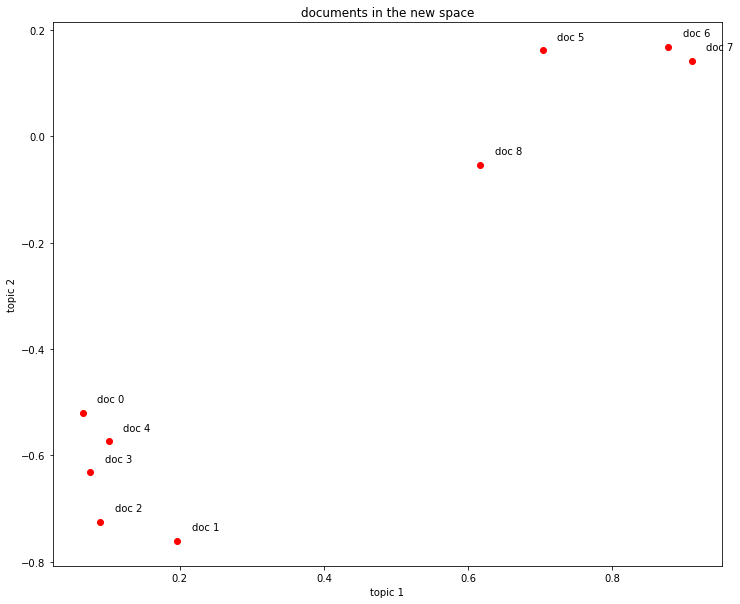

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(12,10))
plt.plot(x,y,'or')
plt.title('documents in the new space')
plt.xlabel('topic 1')
plt.ylabel('topic 2')
#plt.xlim([0,1.1])
#plt.ylim([-0.9,0.3])
s=0.02
for i in range(len(x)):
    plt.text(x[i]+s,y[i]+s,"doc "+str(i))
plt.show()

LSI models can be saved to and loaded from files: 

In [14]:
lsi.save('model.lsi') # same for tfidf, lda, ...
lsi = models.LsiModel.load('model.lsi')